# Super-resolution

This example demonstrates the use of neural operators for
super-resolution.

We will employ the FLAME dataset, a set of flow samples of size 32x32 that
should be up-sampled to 128x128. Download the data set from
[Kaggle](https://www.kaggle.com/competitions/2023-flame-ai-challenge/data)
and put it into the `data/flame` directory.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
import os
os.environ["USE_MPS_BACKEND"] = "0"

In [2]:
import torch
import pathlib
import matplotlib.pyplot as plt
from continuity.data.flame import Flame, FlameDataLoader
from continuity.data.selfsupervised import SelfSupervisedOperatorDataset
from continuity.operators import DeepONet
from continuity.trainer import Trainer
from continuity.trainer.callbacks import PrintTrainingLoss, LearningCurve

In [3]:
torch.manual_seed(1)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Flame

We create a `Flame` data set that reads and exports samples
from the FLAME data. The data set contains train/val splits
and has four channels `ux`, `uy`, `uz`, and `rho`. In this example,
we only use channel `ux` from the first four samples of the val split,
and we visualize the provided data using matplotlib.

In [4]:
N = 4
flame_dir = pathlib.Path.cwd().joinpath("..", "data", "flame")
loader = FlameDataLoader(path=flame_dir)
flame = Flame(loader, size=N, split="val", channels=["ux"])

In [5]:
# Fallback if flame data is not available (e.g. in CI)
if not flame_dir.joinpath("flowfields").is_dir():
    class DummyFlame:
        x = torch.randn(N, 256, 2)
        u = torch.randn(N, 256, 1)
        y = torch.randn(N, 16384, 2)
        v = torch.randn(N, 16384, 1)

        def __getitem__(self, i):
            return self.x[i], self.u[i], self.y[i], self.v[i]

    flame = DummyFlame()

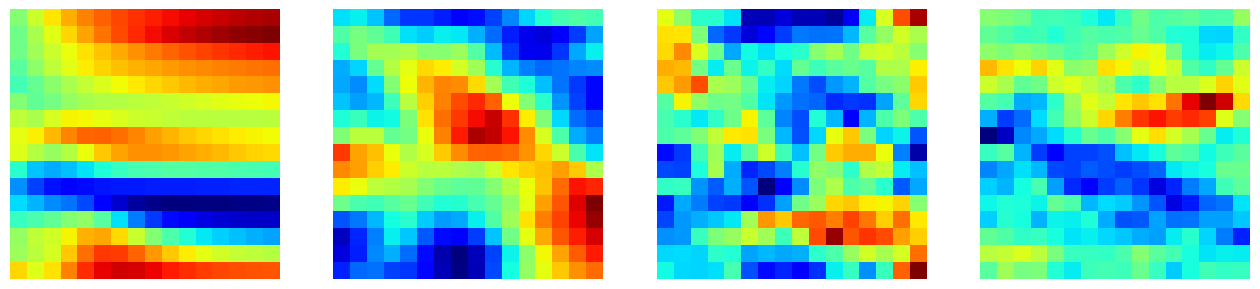

In [6]:
fig, ax = plt.subplots(1, N, figsize=(4 * N, 4))
if N == 1:
    ax = [ax]
for i in range(N):
    u = flame[i][1]
    um = u.reshape((16, 16)).flip(1).T.cpu()
    ms = ax[i].matshow(um, cmap="jet")
    ax[i].axis('off')

## Dataset

We use a `SelfSupervisedOperatorDataset` to create an augmented dataset for function mapping,
containing only data from the low-resolution samples. It creates samples by using one
pixel as label at a time, i.e., 4x16x16 = 1024 samples.

In [7]:
dataset = SelfSupervisedOperatorDataset(flame.x, flame.u)

## Operator

We define a `DeepONet` to map the low-resolution data to a continuous function.

In [8]:
operator = DeepONet(shapes=dataset.shapes, trunk_depth=32)

## Training

With the `OperatorDataSet` at hand, training is straightforward using the `Trainer.fit` method.
Here, we add the `LearningCurve` callback to monitor the training loss.

Model parameters: 45808
Device: cpu
Epoch 100:  loss/train = 4.7701e-02  (0.101 s/epoch)


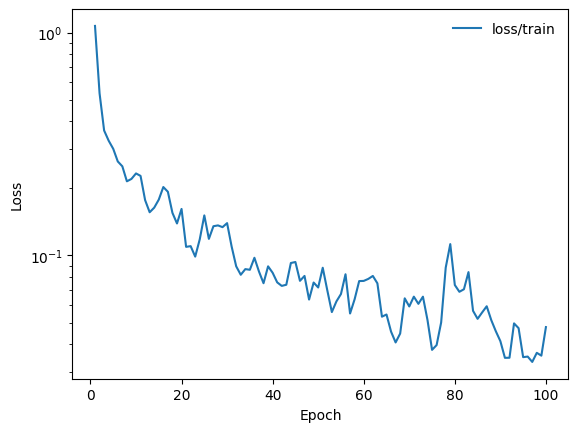

In [9]:
callbacks = [PrintTrainingLoss(), LearningCurve()]
trainer = Trainer(operator)
trainer.fit(dataset, epochs=100, callbacks=callbacks)

## Evaluation

As we can evaluate the trained operator at arbitrary
positions, we can plot the mapped function on a fine mesh
with 100 positions instead of 16 we trained on (super-resolution)!

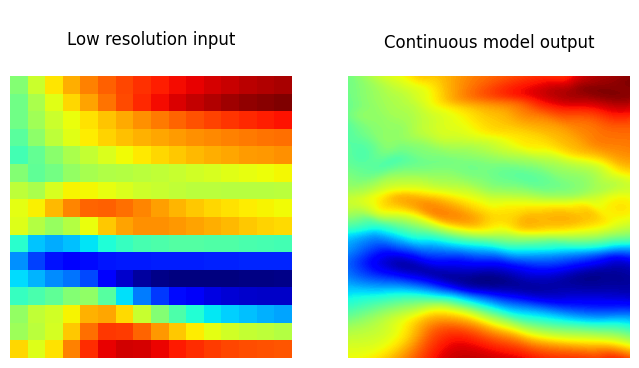

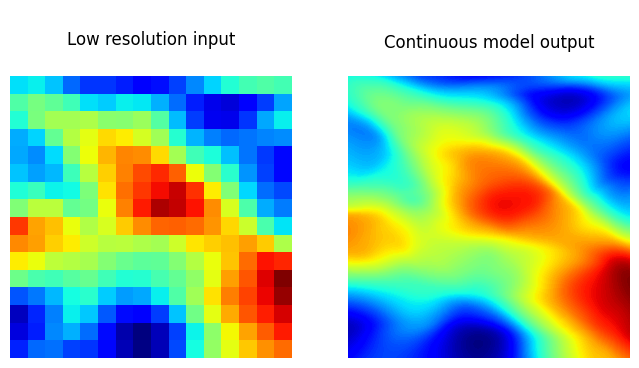

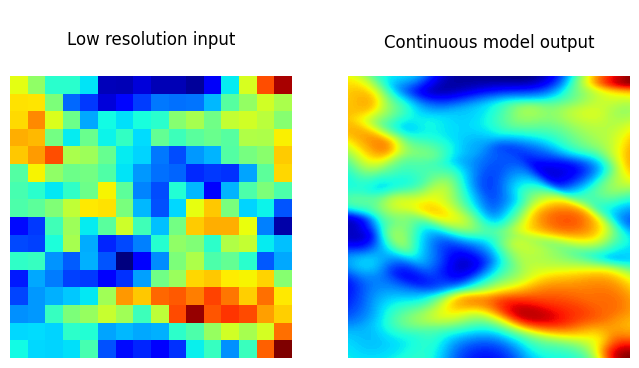

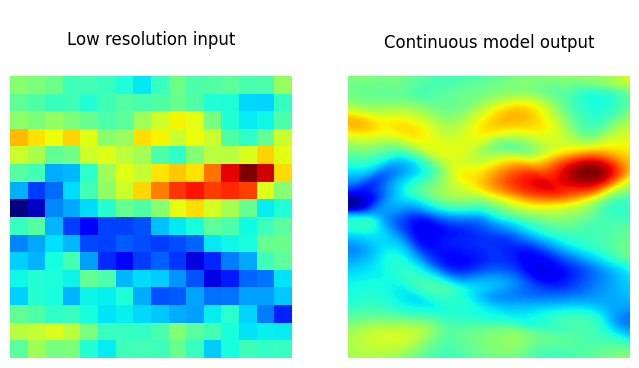

In [10]:
a = torch.linspace(-1, 1, 100) # > 16 (!)
X, Y = torch.meshgrid(a, a, indexing='ij')
yy = torch.stack([X.flatten(), Y.flatten()], dim=1)

for i in range(N):
    x, u, _, _ = flame[i]
    vv = operator(x.unsqueeze(0), u.unsqueeze(0), yy.unsqueeze(0)).squeeze(0)
    vv = vv.detach().cpu().reshape(X.shape)

    _, ax = plt.subplots(1, 2, figsize=(8, 4))
    um = u.reshape((16, 16)).flip(1).T.cpu()
    ax[0].matshow(um, cmap="jet")
    ax[1].contourf(X, Y, vv, levels=200, cmap='jet')
    ax[1].set_aspect('equal')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title("\nLow resolution input")
    ax[1].set_title("Continuous model output\n")
    plt.show()